###**Eutrofización**

##Base de datos

In [ ]:
import os
fname = os.path.join("datos completos.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:137]
print(header)
print(len(lines))

['\ufeffMes', 'OD', 'Chl-A', 'Temp. sup.', 'Nitrato', 'Fosforo']
136


In [ ]:
import numpy as np
clorofila = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    clorofila[i] = values[1]
    raw_data[i, :] = values[:]


In [ ]:
len(clorofila)

136

In [ ]:
len(raw_data)

136

##Grafica de la clorofila (series de tiempo)

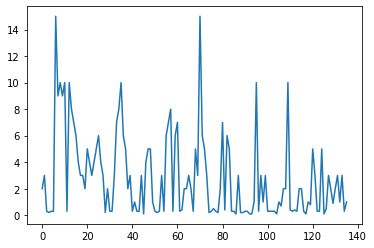

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(clorofila)), clorofila)

##Graficando los primeros 50 datos

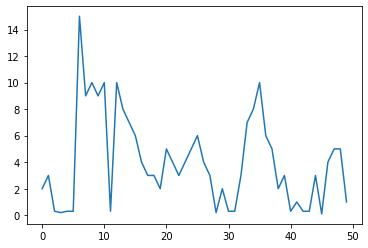

In [ ]:
plt.plot(range(50), clorofila[:50])

##Tomando las muestras para entrenamiento

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 68
num_val_samples: 34
num_test_samples: 34


##Preparando los datos 

#Normalisando los datos 

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

##Tomando los primeros datos 

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


##Iniciando el dataser de entrenamiento, validacion y prueba 

In [ ]:
sampling_rate = 1 #Observations will be sampled at one data point per hour: we will only keep one data point per hour 
sequence_length = 10 #Observations will go back 5 days (120 hours)
delay = sampling_rate * (sequence_length + 14 - 1) #The tareget for a sequence will be the temperature 24 hours after the end of the sequence
batch_size = 34 #number of samples, most be the same at train,val and test

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=clorofila[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=clorofila[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=clorofila[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (34, 10, 5)
targets shape: (34,)


#A common-sense, non-machine-learning baseline

##Computing the common-sense baseline MAE

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.83
Test MAE: 0.15


##Let's try a basic machine-learning model

##Training and evaluating a densely connected model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(26, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
2/2 [==============================] - 1s 167ms/step - loss: 22.3598 - mae: 3.3780 - val_loss: 7.8051 - val_mae: 1.5445
Epoch 2/10
2/2 [==============================] - 0s 90ms/step - loss: 20.8988 - mae: 3.2398 - val_loss: 7.5704 - val_mae: 1.4722
Epoch 3/10
2/2 [==============================] - 0s 77ms/step - loss: 19.9652 - mae: 3.1541 - val_loss: 7.4045 - val_mae: 1.4208
Epoch 4/10
2/2 [==============================] - 0s 80ms/step - loss: 19.2396 - mae: 3.0809 - val_loss: 7.2542 - val_mae: 1.3812
Epoch 5/10
2/2 [==============================] - 0s 77ms/step - loss: 18.5668 - mae: 3.0208 - val_loss: 7.1412 - val_mae: 1.3580
Epoch 6/10
2/2 [==============================] - 0s 79ms/step - loss: 17.9527 - mae: 2.9635 - val_loss: 7.0486 - val_mae: 1.3628
Epoch 7/10
2/2 [==============================] - 0s 73ms/step - loss: 17.3901 - mae: 2.9042 - val_loss: 6.9757 - val_mae: 1.3726
Epoch 8/10
2/2 [==============================] - 0s 75ms/step - loss: 16.8907 - mae: 2.8

##Plotting results

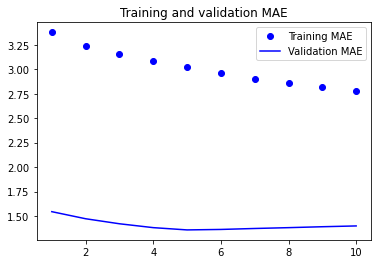

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#A first recurrent baseline

##A simple LSTM-based model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
2/2 [==============================] - 3s 540ms/step - loss: 18.9013 - mae: 3.1535 - val_loss: 10.0959 - val_mae: 1.7896
Epoch 2/10
2/2 [==============================] - 0s 74ms/step - loss: 18.5495 - mae: 3.1052 - val_loss: 10.0006 - val_mae: 1.7635
Epoch 3/10
2/2 [==============================] - 0s 75ms/step - loss: 18.2905 - mae: 3.0718 - val_loss: 9.9183 - val_mae: 1.7418
Epoch 4/10
2/2 [==============================] - 0s 78ms/step - loss: 18.0710 - mae: 3.0442 - val_loss: 9.8475 - val_mae: 1.7227
Epoch 5/10
2/2 [==============================] - 0s 79ms/step - loss: 17.8564 - mae: 3.0146 - val_loss: 9.7801 - val_mae: 1.7045
Epoch 6/10
2/2 [==============================] - 0s 76ms/step - loss: 17.6601 - mae: 2.9912 - val_loss: 9.7076 - val_mae: 1.6864
Epoch 7/10
2/2 [==============================] - 0s 77ms/step - loss: 17.4615 - mae: 2.9652 - val_loss: 9.6419 - val_mae: 1.6709
Epoch 8/10
2/2 [==============================] - 0s 118ms/step - loss: 17.2580 - mae: 

#Understanding recurrent neural networks
NumPy implementation of a simple RNN

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

#A recurrent layer in Keras
An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

#An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

#An RNN layer that returns its full output sequence

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

#Stacking RNN layers

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

#Advanced use of recurrent neural networks
Using recurrent dropout to fight overfitting
Training and evaluating a dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

#Stacking recurrent layers
Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#Using bidirectional RNNs
Training and evaluating a bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)